## MATH2319 Machine Learning Project Phase 2
                                                                                           
  ## Predicting if the client will subscribe (yes/no) a term deposit










                                                                                 
                                                                                                
                                                                                                   









  >  **Names**: Junaid Ahmed Syed & Saikat Mitra
 
 
 
 
 >  **Student ID's**: s3731300 & s3726313
  
  
  
  
  






# Introduction

The Goal of this project is to fit and compare 3 classifiers of binary cardinality to predict if the client will subscribe (yes/no) to a term deposit using the 1994 US Census Data sourced from the UCI Machine Learning Repository<strong data-cite="bank_uci">(UCI, 2014)</strong>.. There are 20 descriptive features out of which 10 are numeric and 9 nominal categorical features and 1 ordinal categorical feature. The target feature has two classes defined as "no" and "yes" respectively. The full dataset contains about 45K observations. This report is a continuation of phase 1 which has included a brief description, pre-processing and visualization of the data.
This report is organized as follows. Section 2  (Overview)  our methodology. Section 3 involves  (Data Preparation)  data pre-processing. In Section 4, we have done the hyperparameter tuning process for each classification algorithm. In Section 5  (Performance Comparison) we present model performance comparison. Section 6  discusses the limitations of our approach. In the last section is to present a brief summary.

# Overview
The strategy of modelling starts with cleaning the full dataset which has been done in  Phase I. This transformation further includes encoding both nominal and ordinal categorical descriptive features as numerical and then normalising the data of descriptive features using MinMax Scaler. We first randomly sample 5K rows from the full dataset and then split this sample into training and test sets with a 70:30 ratio. Then our train dataset has 3.5K rows and test dataset has 1.5K rows.


Out of all 20 features,  10 features are selected using Random Forest Importance method inside a pipeline. We consider 10, 20, and the full set of features (with 50 features)

Using feature selection together with hyperparameter search inside a single pipeline, we conduct 5-fold stratified cross-validation to fine-tune hyperparameters to each of the following classifiers using the area under the curve (AUC) as the performance.

* K-Nearest Neighbors (KNN),
* Decision trees (DT), and
* Naive Bayes (NB).

The best parameters will be identified for each of the three classifier types using a hyperparameter search on the training data. Then we conduct 10-fold cross-validation on the test data and perform a paired t-test. In addition, we compare the classifiers with respect to their recall scores, confusion matrices and accuracy_scores on the test data.


# Data Preparation
## Loading Dataset



In [1]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd


Bank_ds = pd.read_csv('bank-additional-full.csv', sep=';')

print(Bank_ds.shape)

Bank_ds.columns.values

(41188, 21)


array(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'], dtype=object)

## Shape of the dataset
First we check the shape of the dataset to confirm that the features are matched with the description as outlined in the document.

In [2]:
print("Dimension of the data set is{Bank.shape}\n")
print("Data Types are:")
print(Bank_ds.dtypes)

Dimension of the data set is{Bank.shape}

Data Types are:
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object


We are dropping 3 columns from the dataset as from the the visualisations which were done phase 1 report,we can see that these columns has no predictive power. 

In [3]:
Bank_ds=Bank_ds.drop(['duration'],1)
Bank_ds=Bank_ds.drop(['poutcome'],1)

## Checking for missing values
 We can see that there are no missing values in the data.

In [4]:
Bank_ds.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

## Encoding Categorical Descriptive Features
Seperating target and descriptive features and labeling them as Bank and target respectively.

In [5]:
Bank = Bank_ds.drop(columns='y')
target = Bank_ds['y']
target.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

### Encoding Target variable 
To encode Target variable as 0 and 1 we use LableEncoder from the sklearn preprocessing module.

In [6]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le_fit = le.fit(target)
target = le_fit.transform(target)

### Encoding Categorical Descriptive Features

#### Integer-encoding for ordinal Categorical Features


Among all the descriptive features, `education` column is ordinal so we have used integer encoding for ordinal categorical features and labelled them with integer starting from 0 to 7 using replace function.  

In [7]:

level_mapping = {'unknown': 0, 'illiterate': 1, 'basic.4y': 2,'basic.6y': 3,'basic.9y': 4,
                 'high.school': 5, 'university.degree': 6,'professional.course': 7}
Bank['education'] = Bank['education'].replace(level_mapping)
Bank['education'].value_counts()

6    12168
5     9515
4     6045
7     5243
2     4176
3     2292
0     1731
1       18
Name: education, dtype: int64

#### Hot-encoding for Nomial Categorical Features

For converting Nomial Categorical Features to numerical we did one-hot encoding we defined a custom function for each two-level categorical variable. For columns of level 0,1 we set the drop_first option to true to encode them into a single column and for the columns more than 2 levels we apply the get_dummies()  for the regular one-hot encoding.

In [8]:
categorical = Bank.columns[Bank.dtypes==object].tolist()

for col in categorical:
    n = len(Bank[col].unique())
    if (n == 2):
        Bank[col] = pd.get_dummies(Bank[col], drop_first=True)

Bank = pd.get_dummies(Bank)

After this step , we can see that the  Descriptive feature set has 50 columns.

In [9]:
Bank.columns

Index(['age', 'education', 'contact', 'campaign', 'pdays', 'previous',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'month_apr', 'month_aug', 'month_dec',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon',
       'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed'],
      dtype='object')

## Scaling Descriptive Features
After converting all the features to numeric, we normalized them by using MinMax Scalar. Before doing that, we save a normal copy of data.

In [10]:
Bank_df = Bank.copy()
Scaler = preprocessing.MinMaxScaler()
Scaler.fit(Bank)
Bank = Scaler.fit_transform(Bank)

## Feature selection
For Simplicity, we are selecting 10 most important features  selected by Random Forest Importance (RFI) from the full dataset. This is for a quick ranking of the most relevant 10 features to gain some insight into the problem at hand. During the hyperparameter tuning phase, we will include RFI as part of the pipeline and we will search over 10, 20, and the full set of 50 features to determine which number of features works best with each classifier.

In [11]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
num_features = 10
model_rfi = RandomForestClassifier(n_estimators=100)
model_rfi.fit(Bank, target)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]

best_features_rfi = Bank_df.columns[fs_indices_rfi].values
best_features_rfi

array(['age', 'euribor3m', 'campaign', 'education', 'pdays',
       'nr.employed', 'emp.var.rate', 'previous', 'cons.price.idx',
       'cons.conf.idx'], dtype=object)

In [12]:
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
feature_importances_rfi

array([0.17227963, 0.12457136, 0.08652432, 0.07071197, 0.05193277,
       0.04711875, 0.02995865, 0.02876424, 0.02340576, 0.02075894])

- Visualising the important features


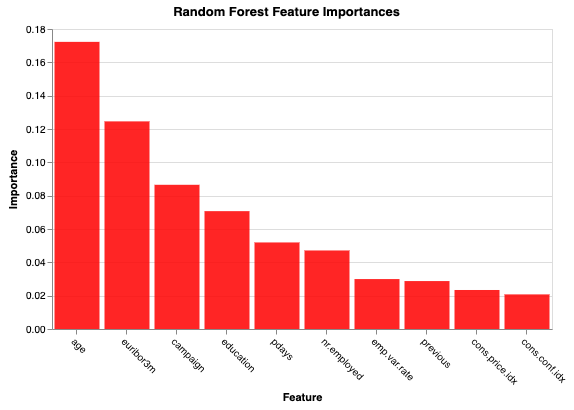

In [13]:
import altair as alt

def plot_imp(best_features, scores, method_name, color):
    
    df = pd.DataFrame({'features': best_features, 
                       'importances': scores})
    
    chart = alt.Chart(df, 
                      width=500, 
                      title=method_name + ' Feature Importances'
                     ).mark_bar(opacity=0.85, 
                                color=color).encode(
        alt.X('features', title='Feature', sort=None, axis=alt.AxisConfig(labelAngle=45)),
        alt.Y('importances', title='Importance')
    )
    
    return chart

plot_imp(best_features_rfi, feature_importances_rfi, 'Random Forest', 'red')

## Data Sampling & Train-Test Splitting
The full dataset has more than 45K rows. So, we have randomly selected a small sample of  5K rows and Split this sample into train and test with a ratio of  70:30 ratio using the stratification method.

In [14]:
sample = 5000

Data_s = pd.DataFrame(Bank).sample(n=sample, random_state=8).values
target_s = pd.DataFrame(target).sample(n=sample, random_state=8).values

print(Data_s.shape)
print(target_s.shape)

(5000, 51)
(5000, 1)


In [15]:
from sklearn.model_selection import train_test_split

DStrain, DStest, \
TStrain, TStest = train_test_split(Data_s, target_s, 
                                                    test_size = 0.3, random_state=999,
                                                    stratify = target_s)

print(DStrain.shape)
print(DStest.shape)

(3500, 51)
(1500, 51)


## Model Evaluation Strategy

So, we shall be training and tuning our models on 3.5K rows of training data and we will test them on 1.5K rows of test data.

For each these models, we will utilize 5-crease stratified cross-approval assessment strategy (with no reiterations for shorter run times) for hyperparameter tuning.

In [16]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

cv_method = StratifiedKFold(n_splits=5, random_state=999)

# Hyperparameter Tuning 

## K-Nearest Neighbors (KNN)

Using Pipeline, we stack feature selection and grid search for KNN hyperparameter tuning via cross-validation. We will use the same Pipeline methodology for NB and DT.

The KNN hyperparameters are as follows:

number of neighbours (n_neighbors) and
the distance metric p.
For feature selection, we use the powerful Random Forest Importance (RFI) method with 100 estimators, we define the custom RFIFeatureSelector() class below to pass in RFI as a "step" to the pipeline to make RFI feature selection as part of the pipeline.

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

# custom function for RFI feature selection inside a pipeline
# here we use n_estimators=100
class RFIFeatureSelector(BaseEstimator, TransformerMixin):
    
    # class constructor 
    # make sure class attributes end with a "_"
    # per scikit-learn convention to avoid errors
    def __init__(self, n_features_=10):
        self.n_features_ = n_features_
        self.fs_indices_ = None

    # override the fit function
    def fit(self, X, y):
        from sklearn.ensemble import RandomForestClassifier
        from numpy import argsort
        model_rfi = RandomForestClassifier(n_estimators=100)
        model_rfi.fit(X, y)
        self.fs_indices_ = argsort(model_rfi.feature_importances_)[::-1][0:self.n_features_] 
        return self 
    
    # override the transform function
    def transform(self, X, y=None):
        return X[:, self.fs_indices_]

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

pipe_KNN = Pipeline(steps=[('rfi_fs', RFIFeatureSelector()), 
                           ('knn', KNeighborsClassifier())])

params_pipe_KNN = {'rfi_fs__n_features_': [10, 20, Bank.shape[1]],
                   'knn__n_neighbors': [1, 10, 20,40,60,100],
                   'knn__p': [1, 2]}

GridSearchCVKNN = GridSearchCV(estimator=pipe_KNN, 
                           param_grid=params_pipe_KNN, 
                           cv=cv_method,
                           refit=True,
                           n_jobs=-2,
                           scoring='roc_auc',
                           verbose=1)

In [19]:
GridSearchCVKNN.fit(DStrain, TStrain);

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-2)]: Done 180 out of 180 | elapsed:   47.5s finished


In [20]:
GridSearchCVKNN.best_params_

{'knn__n_neighbors': 100, 'knn__p': 1, 'rfi_fs__n_features_': 10}

In [21]:
GridSearchCVKNN.best_score_

0.7594934714541964

We can see that the best  KNN model given by the grid search method has an average AUC score of 0.759. The best accomplishing KNN selected 10 features with 100 nearest neighbours and 𝑝=1.


let's see the other combinations to see if the difference is rather meaningful or not. To do that, we will make use of the function below to format the grid search outputs as pd.

In [22]:
def get_search_results(gs):

    def model_result(scores, params):
        scores = {'mean_score': np.mean(scores),
             'std_score': np.std(scores),
             'min_score': np.min(scores),
             'max_score': np.max(scores)}
        return pd.Series({**params,**scores})

    models = []
    scores = []

    for i in range(gs.n_splits_):
        key = f"split{i}_test_score"
        r = gs.cv_results_[key]        
        scores.append(r.reshape(-1,1))

    all_scores = np.hstack(scores)
    for p, s in zip(gs.cv_results_['params'], all_scores):
        models.append((model_result(s, p)))

    pipe_results = pd.concat(models, axis=1).T.sort_values(['mean_score'], ascending=False)

    columns_first = ['mean_score', 'std_score', 'max_score', 'min_score']
    columns = columns_first + [c for c in pipe_results.columns if c not in columns_first]

    return pipe_results[columns]


In [23]:
results_KNN = get_search_results(gs_pipe_KNN)
results_KNN.head()

NameError: name 'gs_pipe_KNN' is not defined


- visualising these results

In [ ]:
import altair as alt

results_KNN_10_features = results_KNN[results_KNN['rfi_fs__n_features_'] == 10.0]

alt.Chart(results_KNN_10_features, 
          title='KNN Performance Comparison with 10 Features'
         ).mark_line(point=True).encode(
    alt.X('knn__n_neighbors', title='Number of Neighbors'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False)),
    alt.Color('knn__p:N', title='p')
)

## (Gaussian) Naive Bayes (NB)

For Implementing a Gaussian Naive Bayes model, we optimize var_smoothing (a variation of Laplace smoothing) as we don't have any earlier data about our dataset. Of course, the var_smoothing parameter's esteem is 10−9. We lead the lattice search in the log space (over the forces of 10) sourced from NumPy. We begin with 10 and end with 10−3 with 200 different values, however, we perform a random search over only 20 different values (for shorter run times). Since NB requires each descriptive feature to follow a Gaussian Distribution, we initially play out a power change(Transformation) on the information before model fitting.

In [ ]:
from sklearn.preprocessing import PowerTransformer
DStransformed = PowerTransformer().fit_transform(DStrain)

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV

pipe_NB = Pipeline([('rfi_fs', RFIFeatureSelector()), 
                     ('nb', GaussianNB())])

params_pipe_NB  = {'rfi_fs__n_features_': [10, 20, Bank.shape[1]],
                  'nb__var_smoothing': np.logspace(1,-3,num=200)}

n_iter_search = 20
gs_pipe_NB = RandomizedSearchCV(estimator=pipe_NB, 
                          param_distributions=params_pipe_NB, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          n_iter=n_iter_search,
                          verbose=1) 

gs_pipe_NB.fit(DStransformed, TStrain);

In [ ]:
gs_pipe_NB.best_params_

In [ ]:
gs_pipe_NB.best_score_

The best NB has an AUC score of 0.754 with 50 features, which is slightly less than KNN.we can also see that the with gridsearch the optimal number of features is 50 rather than 10.



In [ ]:
results_NB = get_search_results(gs_pipe_NB)
results_NB.head()

- visualize the search results.

In [ ]:
results_NB_10_features = results_NB[results_NB['rfi_fs__n_features_'] == 10.0]

alt.Chart(results_NB_10_features, 
          title='NB Performance Comparison with 10 Features'
         ).mark_line(point=True).encode(
    alt.X('nb__var_smoothing', title='Var. Smoothing'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False))
)

## Decision Tree (DT)
We build a Decision Tree model using the Gini Index to increase Information Gain. We aim to determine the best values of maximum depth (max_depth) and minimum sample split (min_samples_split). We conduct the grid search with values of 3, 5,7,9 for  max_depth and 5,10,15 for  min_samples_split.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

pipe_DT = Pipeline([('rfi_fs', RFIFeatureSelector()),
                    ('dt', DecisionTreeClassifier(criterion='gini'))])
params_pipe_DT = {'rfi_fs__n_features_': [10, 20, Bank.shape[1]],
                  'dt__max_depth': [3, 5, 7, 9],
                  'dt__min_samples_split': [5, 10, 15]}

gs_pipe_DT = GridSearchCV(estimator=pipe_DT, 
                          param_grid=params_pipe_DT, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          verbose=1) 

gs_pipe_DT.fit(DStrain, TStrain);

In [ ]:
gs_pipe_DT.best_params_

In [ ]:
gs_pipe_DT.best_score_

The optimal DT has a dt_max_depth of 3 and dt__min_samples_split value of 5 samples with an AUC score of 0.73. 
- A visualization of the search results is given below

In [ ]:
results_DT = get_search_results(gs_pipe_DT)

results_DT_10_features = results_DT[results_DT['rfi_fs__n_features_'] == 10.0]

alt.Chart(results_DT_10_features, 
          title='DT Performance Comparison with 10 Features'
         ).mark_line(point=True).encode(
    alt.X('dt__min_samples_split', title='Min Samples for Split'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False)),
    alt.Color('dt__max_depth:N', title='Max Depth')
)

# Performance Comparision
We have improved every last one of the three classifiers utilizing the train data. We currently fit the improved models on test data in a cross-validated style. Be that as it may, since cross validation itself is a random procedure, we perform pairwise t-tests to decide whether any contrast between the exhibition of any two optimized classifiers that are statistically significant. To start with, we perform 10-fold stratified cross-validation on each best model (with no redundancies). Second, we lead a paired t-test for the AUC score between the accompanying model combinations:

KNN vs. NB,


KNN vs. DT, and


DT vs. NB.

In [ ]:
from sklearn.model_selection import cross_val_score

cv_method_ttest = StratifiedKFold(n_splits=10, random_state=999)

cv_results_KNN = cross_val_score(estimator=gs_pipe_KNN.best_estimator_,
                                 X=DStest,
                                 y=TStest,
                                 cv=cv_method_ttest,
                                 n_jobs=-2,
                                 scoring='roc_auc')
cv_results_KNN.mean()

In [ ]:
DStransformed = PowerTransformer().fit_transform(DStest)

cv_results_NB = cross_val_score(estimator=gs_pipe_NB.best_estimator_,
                                X=DStransformed,
                                y=TStest, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='roc_auc')
cv_results_NB.mean()

In [ ]:
cv_results_DT = cross_val_score(estimator=gs_pipe_DT.best_estimator_,
                                X=DStest,
                                y=TStest, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='roc_auc')
cv_results_DT.mean()

In [ ]:
from scipy import stats

print(stats.ttest_rel(cv_results_KNN, cv_results_NB))
print(stats.ttest_rel(cv_results_DT, cv_results_KNN))
print(stats.ttest_rel(cv_results_DT, cv_results_NB))

we can see that at a 95% significance level, KNN is measurably the best model

Though we used AUC to optimize the algorithm hyperparameters, we shall consider the following metrics to evaluate models based on the test set:

- Accuracy
- Precision
- Recall
- F1 Score (the harmonic average of precision and recall)
- Confusion Matrix


These metrics can be computed using classification_report from sklearn.metrics. The classification reports are shown below.

In [ ]:
pred_KNN = gs_pipe_KNN.predict(DStest)

In [ ]:
Data_test_transformed = PowerTransformer().fit_transform(DStest)
pred_NB = gs_pipe_NB.predict(DStransformed)

In [ ]:
pred_DT = gs_pipe_DT.predict(DStest)

In [ ]:
from sklearn import metrics
print("\nClassification report for K-Nearest Neighbor") 
print(metrics.classification_report(TStest, pred_KNN))
print("\nClassification report for Naive Bayes") 
print(metrics.classification_report(TStest, pred_NB))
print("\nClassification report for Decision Tree") 
print(metrics.classification_report(TStest, pred_DT))

In [ ]:
from sklearn import metrics
print("\nConfusion matrix for K-Nearest Neighbor") 
print(metrics.confusion_matrix(TStest, pred_KNN))
print("\nConfusion matrix for Naive Bayes") 
print(metrics.confusion_matrix(TStest, pred_NB))
print("\nConfusion matrix for Decision Tree") 
print(metrics.confusion_matrix(TStest, pred_DT))

Since we would pick recall as the performance metric, which is comparable to the true positive rate (TPR). In this unique circumstance, DT would be the best performer since it delivers the most astounding recall score for customers who subscribed to a term deposit. The confusion matrices are in accordance with the classification reports. This is in a contrast to our finding that KNN is measurably the best model with regards to the AUC metric.

# Limitations and Proposed Solutions 
Our modelling strategy has a couple of imperfections and confinements. To start with, ours was a black-box approach since we preferred raw predictive performance over interpretability. Later on, In the future, we could consider a more inside and out an investigation of feature selection & ranking process as well as our choices for the hyperparameter spaces.

Second, we used a blanket power transformation on the training data when building the NB, disregarding the dummy features in the dataset. This may somewhat clarify the poor execution of the NB when assessed on the test set. A potential solution is to build a Gaussian NB and a Bernoulli NB independently on the numerical and dummy descriptive features individually. At that point, we can compute a final prediction by multiplying predictions from each model since NB assumes inter-independence conditioned on the value of the target feature.

Third, The feature selection with ten best features hasn't worked well. We have seen 20 and 51 as the best number of features. For this, in future, we can increase the number of important features and check whether we get Better Results.

Lastly, we just worked with a little subset of the full dataset for shorter run times, both for preparing and testing. Since information is constantly significant, we could re-run our trials with the whole information while ensuring that the train and test split is performed in a legitimate manner.


The KNN classifier statistically outperforms the other two models. Therefore, we can perhaps improve it by further expanding the hyperparameter search space by including other parameters of this classification method. Furthermore, we can consider random forests and other ensemble methods built on trees as potentially better models.

- 

# Summary 
The K-Nearest Neighbors (KNN) model with 10 of the best features chosen by Random Forest Importance (RFI) produces the highest cross-validated AUC score on the train data. Also, when assessed on the test set, the Decision Tree model got high precision score and most astounding review score which again beats both Naive Bayes and k-Nearest Neighbor models concerning AUC. Since we can see that the number of features of DT model is 20 and 51 for NB model We can observe that our models is sensitive to the number of features. For this reason, we should work with full feature set.

# References
* S. Moro, P. Cortez and P. Rita,(2014),Bank-Marketing Data Set,https://archive.ics.uci.edu/ml/datasets/Bank+Marketing